In [ ]:
import os
import keras
from keras import layers, models #für die einzelnen Schichten im CNN (Faltung, Pooling und vollstädig verknüpfte Layer)
import tensorflow as tf #Tensorflow zur Bildklassifizierung
tf.config.run_functions_eagerly(True)
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout, Flatten #fürs CNN Modell (Vektor 1D und Dense Layer)
from keras.layers import Conv2D, MaxPooling2D ,BatchNormalization #fürs CNN Modell (Faltung und Verkleinern)
from keras.preprocessing import image
import numpy as np #für Confusion matrix
import pandas as pd
import matplotlib.pyplot as plt #zum anzeigen der Bilder visuell
import seaborn as sns
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import ImageDataGenerator #Klasse in TensorFlow -> lädt Bilder automatisch, normalisiert, dreht, spiegelt und so
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau #fürs model.compile -> Vorbereitung Daten fürs Training
from PIL import Image #öffnet Bild aus Pfad
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report #für Confusion Matrix

In [14]:
#Pfad zum Ordner, der die Bilder enthält (mit den Unterordnern "Brain Tumor" und "Healthy") -> Daten laden
daten_pfad = "C:/Users/Conny/Documents/FH Bioengineering/6. Semester/Bachelorarbeit/Brain Tumor Data Set/Brain Tumor Data Set"

In [15]:
#os.listdir(...) -> gibt eine Liste mit den Namen der Dateien im Verzeichnis zurück -> also alles was unter dem angegeben Verzeichnis zu finden ist
#os.path.join -> verbindet mehrere Pfade wie z.B. der Pfad zu den Unterordern im Verzeichnis verbunden mit den Inhalt unter den Unterordnern,
#also die Anzahl der Bilder -> gibt den vollständigen Pfad an
#len(os.listdir(....)) -> Gibt die Anzahl der Elemente in einem Ordner/Verzeichnis zurück
#len alleine gibt die Länge der Zeichen eines Objektes zurück z.B. wie lange ein 'Wort' ist mit den Buchstaben (Strings)
for unterordner in os.listdir(daten_pfad):
    print(unterordner, "Ordner enthält:",len(os.listdir(os.path.join(daten_pfad, unterordner))), 'MRT-Bilder')

Brain Tumor Ordner enthält: 2513 MRT-Bilder
Healthy Ordner enthält: 2087 MRT-Bilder


C:/Users/Conny/Documents/FH Bioengineering/6. Semester/Bachelorarbeit/Brain Tumor Data Set/Brain Tumor Data Set\Brain tumor
['Cancer (1).jpg', 'Cancer (1).png', 'Cancer (1).tif', 'Cancer (10).jpg', 'Cancer (10).tif', 'Cancer (100).jpg', 'Cancer (1000).jpg', 'Cancer (1001).jpg', 'Cancer (1002).JPG', 'Cancer (1003).jpg', 'Cancer (1004).jpg', 'Cancer (1005).jpg', 'Cancer (1006).jpg', 'Cancer (1007).jpg', 'Cancer (1008).jpg', 'Cancer (1009).jpg', 'Cancer (101).jpg', 'Cancer (1010).jpg', 'Cancer (1011).jpg', 'Cancer (1012).JPG', 'Cancer (1013).JPG', 'Cancer (1014).jpg', 'Cancer (1015).jpg', 'Cancer (1016).JPG', 'Cancer (1017).jpg', 'Cancer (1018).jpg', 'Cancer (1019).jpg', 'Cancer (102).jpg', 'Cancer (1020).jpg', 'Cancer (1021).jpg', 'Cancer (1022).jpg', 'Cancer (1023).jpg', 'Cancer (1024).JPG', 'Cancer (1025).JPG', 'Cancer (1026).JPG', 'Cancer (1027).JPG', 'Cancer (1028).jpg', 'Cancer (1029).jpg', 'Cancer (103).jpg', 'Cancer (1030).jpg', 'Cancer (1031).jpg', 'Cancer (1032).jpg', 'Cancer (1

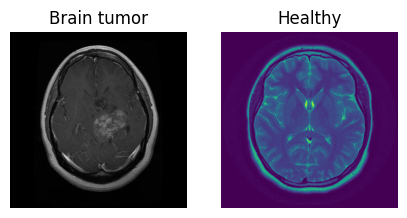

In [16]:
#Bilder anzeigen lassen geteilt in die 2 Klassen: Brain tumor und Healthy
klassen = ["Brain tumor", "Healthy"]

plt.figure(figsize=(5, 2.5)) #ändert Größe der unten angezeigten Bilder, also 10,5 wäre doppelt so groß

for i in range (len(klassen)): #durchläuft Schleife für alle Elemente in der Liste "KLassen" -> also 1x für Brain tumor und 1x für Healthy
    ordner_pfad = os.path.join(daten_pfad, klassen[i]) #Pfad zu Unterordner
    bilddaten = os.listdir(ordner_pfad) #gibt die Liste aller Bildnamen aus, die unter den Ordner zu finden sind, zeigt aber nicht direkt die Bilder an
    print (ordner_pfad)
    print (bilddaten)
    
    bildpfad = os.path.join(ordner_pfad, bilddaten[0])  # Pfad direkt zum erstes Bild -> auswählen mit Position [0]
    bild = Image.open(bildpfad) #Öffnen des ersten Bildes (Pfad von oben)
    print(bildpfad)

    plt.subplot(1, 2, i+1)  # 1 Zeile, 2 Spalten -> Bilder sind nebeneinander
    plt.imshow(bild) #Bild wird richtig visuell angezeit -> würde mit print(img) nicht funktionieren
    plt.axis("off") #ohne Achsen
    plt.title(klassen[i]) #Beschriftung der Bilder -> erstes Bild-Klasse 1; zweites Bild-Klasse 2 -> würde so weiter gehen

#plt.show() #zeigt Bilder an


In [ ]:
#Formatieren und Skalieren der Bilder von Pixel 255 auf 0 - 1 und definieren das 20% Validierungsdaten sind -> somit 80% für Training:
gen_daten =ImageDataGenerator(
                            rescale=1./255, #Bilder bestehen aus Pixeln von 0 bis 255 -> müssen normalisiert werden bevor Modell übergeben -> Bereich zwischen 0 und 1 
                            rotation_range=0, #hilft gegen Überanpassung -> kann Tumor-Erkennung verbessern
                            width_shift_range=0, #zufällige horizontale Verschiebung -> nicht sinnvoll, verschlechtert Genauigkeit
                            height_shift_range=0, #zufällige vertikale Verschiebung -> nicht sinnvoll, verschlechtert Genauigkeit
                            zoom_range=0, #zoom -> nicht sinnvoll, verschlechtert Genauigkeit -> aufpassen, das Tumor im Bild bleibt
                            horizontal_flip=False, #horizontale Spiegelung -> nicht sinnvoll, verschlechtert Genauigkeit
                            validation_split=0.2 #20% werden für Validierung genutzt
) #restlichen Parameter bleiben so wie sie sind -> müssen nicht angeführt werden -> mit help(ImageDataGenerator) ersichtlich

In [ ]:
#Variablen für Bildgröße und Bildanzahl pro Batch
groesse=150
anzahl=64

In [19]:
#Daten für Training und Validierung vorbereiten mit den wichtigsten Parametern -> mit help(gen_daten.flow_from_directory) werden alle Parameter angezeit (nicht relevant)
training = gen_daten.flow_from_directory(daten_pfad, #directory gibt Pfad zu den beiden Unterordner "Brain tumor" und "Healthy" an
                                        target_size=(groesse, groesse), #Bildgröße -> anpassbar, 150 ist mal so Standardwert
                                        batch_size=anzahl, #wie viele Bilder pro 
                                        color_mode="grayscale", #schwarz-weiß Bilder und keine Farbbilder (rgb)
                                        shuffle=True, #mischt Bilder für besseres Training
                                        class_mode="binary", #bei 2 Klassen "binary", bei mehreren KLassen wäre "categorical"
                                        subset="training") #Trennseite für Training -> 80% (training)

validierung = gen_daten.flow_from_directory(daten_pfad,
                                        target_size=(groesse, groesse),
                                        batch_size=anzahl,
                                        color_mode="grayscale",
                                        shuffle=False, #Reihenfolge bleibt erhalten zwecks nachvollziehbarkeit
                                        class_mode="binary",
                                        subset="validation") #Trennseite für Validierung -> 20% (validation)

Found 3681 images belonging to 2 classes.
Found 919 images belonging to 2 classes.


In [20]:
#Folgendes CNN-Modell definiert die "Faltung" (Conv2D) und das "Pooling" (MaxPooling2D) -> also das extrahieren der Infos und das verkleinern der Bilder
#Eingabe in Conv2D: 32-> jede Schicht lernt 32 versch. Merkmale; (3,3) -> Kernelgröße von 3x3 Pixel, die Bild scannen
#activation=relu -> entfernt negative werte (unwichtige Infos) - sorgt für Nicht-Linearität
#Input_shape: Bildgröße (Pixel) -> 150x150, 1, weil schwarz-weiß (3 wäre RGB)
#MaxPooling2D (2,2) -> reduziert die Größe auf die Hälfte also 150x150 auf 75x75
#Pro Layer nimmt man größere Pixel-Anzahl, damit er mehr lernt, aber Bildgröße reduziert sich nach jedem Durchlauf auf die Hälfte
cnn_model = models.Sequential()
cnn_model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(groesse, groesse, 1))) 
cnn_model.add(layers.MaxPooling2D((2, 2)))
cnn_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
cnn_model.add(layers.MaxPooling2D((2, 2)))
cnn_model.add(layers.Conv2D(128, (3, 3), activation='relu'))
cnn_model.add(layers.MaxPooling2D((2, 2)))
#cnn_model.add(layers.Conv2D(256, (3, 3), activation='relu'))
#cnn_model.add(layers.MaxPooling2D((2, 2)))        brauch ich 256 noch?



c:\Users\Conny\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [21]:
#letzte Schicht -> Dense Layer und umwandeln in Vektor
#Flatten wandelt 3D Modell in einen 1D Vektor um -> Vektor wird an Dense Schicht geschickt
#zum Schluss ist Dense 1 (weil binäres Modell, entwder Tumor oder nicht) und activation "sigmoid" (ist eine Funktion und wandelt jede Zahl in Wert zwischen 0 und 1 um)
#0 und 1 deshalb, weil 0 (kein Tumor) oder 1 (Tumor)
cnn_model.add(layers.Flatten())
cnn_model.add(layers.Dense(128, activation='relu')) #passen 128? oder 256 besser?
cnn_model.add(layers.Dense(1,activation="sigmoid"))

In [22]:
#Anzeigen lassen des CNN Modells:
cnn_model.summary()

#Model: sequential_"Zahl" -> Zahl wird fortlaufend hochgezählt, je nach dem wie oft man Model erstellt
#Output: ist "Höhe", "Breite", "Kanäle" -> Breite und Höhe werden um die Hälfte immer kleiner -> dadurch eben Erhöhung der Pixel-Anzahl für Filter, der drüberläuft und lernt

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 148, 148, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     4,735,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,827,905 (18.42 MB)

 Trainable params: 4,827,905 (18.42 MB)

 Non-trainable params: 0 (0.00 B)

In [23]:
#Fertigstellung bzw. Vorbereitung auf Modelltraining -> Methode "compile" in module keras.src.trainers.trainer: ohne compile kann Modell nicht trainiert werden
#optimizer: "adam" bzw. "rmsprop" -> wie lernt Modell, ist ein Optimierungsalgorithmus -> Loss soll minimiert werden
#loss: "binary_crossentropy" -> weil ich nur 2 Klassen (Tumor oder nicht) -> Verlustfunktion - je schlechter das Modell, desto höher Verlust
#metrics: "accuracy" -> Genauigkeit - wie viele wahre Vorhersagen nach jeder Epoche
cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

#Restlichen Parameter werden hier nicht benötigt (mit help ersichtlich)

In [ ]:
#Epochen definieren -> wie oft sollen Trainingsbilder durchlaufen werden -> in Modul keras.src.backend.tensorflow.trainer:
#"training x" sind meine Trainingsdaten von oben, "validierung" sind Validierungsdaten von oben -> wurden mit ImageGenerator definiert
#verbose: Anzeigeeinstellung: 0 (keine ANzeigedaten), 1 (Details), 2 (nur Anzahl der Epoche)
#Earlystopping ist dafür da, wenn sich Modell nach 5 Epochen (patience=5) nicht verbessert -> Abbruch, restore_best_weights -> stellt Epochen mit niedrigsten loss wieder her
#Modelcheckpoint speichert Modell automatisch, wenn es besser wird
#callbacks: hier werden die callbacks "Earlystops und Modelcheckpoint" definiert
#58 Schritte -> 80% Training von 4600 Bilder ergibt 3680 Bilder, Batch Size=64 -> 3680/64=57,5 = 58
earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5,restore_best_weights=True)
modelcheckpoint = ModelCheckpoint("BraintumorData.keras", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

history = cnn_model.fit(x=training, epochs=10,  #reichen 10?
                    verbose=1,callbacks=[earlystop,modelcheckpoint],validation_data=(validierung)) #benötige ich callbacks?

c:\Users\Conny\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10


c:\Users\Conny\AppData\Local\Programs\Python\Python312\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6277 - loss: 0.6398
Epoch 1: val_accuracy improved from -inf to 0.82699, saving model to BraintumorData.keras
58/58 ━━━━━━━━━━━━━━━━━━━━ 128s 2s/step - accuracy: 0.6291 - loss: 0.6382 - val_accuracy: 0.8270 - val_loss: 0.3995
Epoch 2/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8604 - loss: 0.3546
Epoch 2: val_accuracy did not improve from 0.82699
58/58 ━━━━━━━━━━━━━━━━━━━━ 125s 2s/step - accuracy: 0.8602 - loss: 0.3547 - val_accuracy: 0.8030 - val_loss: 0.4235
Epoch 3/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8749 - loss: 0.2905
Epoch 3: val_accuracy improved from 0.82699 to 0.91839, saving model to BraintumorData.keras
58/58 ━━━━━━━━━━━━━━━━━━━━ 128s 2s/step - accuracy: 0.8754 - loss: 0.2897 - val_accuracy: 0.9184 - val_loss: 0.2011
Epoch 4/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9433 - loss: 0.1607
Epoch 4: val_accuracy did not improve from 0.91839
58/58 ━━━━━━━━━━━━━━━━━━━━ 127s 2s/step - accu

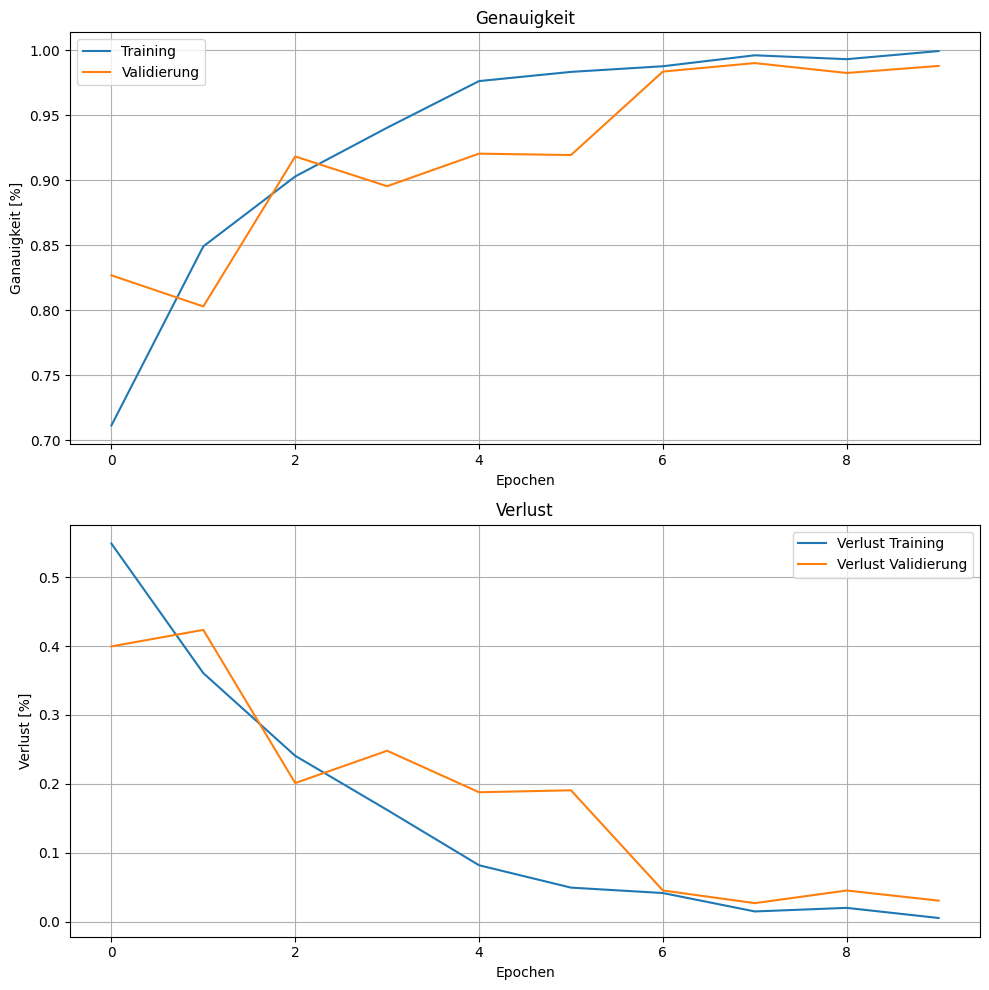

In [ ]:
#Plotten der Genauigkeit und des Verlusts in 2 extra Plots mit Training und Validierung:

plt.figure(figsize=(10, 10)) #generelle Plotgröße von beiden Subplots

#Trainings- und Validierungsgenauigkeiten (Accuracy)
plt.subplot(2, 1, 1) #2=2 Zeilen, 1= 1 Spalte, 1= erster Subplot
plt.plot(history.history['accuracy'], label='Training') #history.history -> 1.ist meine vergebene Variable, 2.ist funktion; [accuracy] greift auf Genauigkeit zu; label= Legende der Linie
plt.plot(history.history['val_accuracy'], label='Validierung') #2. Darstellungsgraph Validierungsgenauigkeit
plt.title('Genauigkeit') #Titel des gesamten Subplots
plt.xlabel('Epochen') #Benennung der x-Achse
plt.ylabel('Ganauigkeit [%]') #Benennung y-Achse
plt.legend() #zeigt Legende an -> "Validierung und Training"
plt.grid(True) #Gitternetzlinien anzeigen -> Ja

# Trainings- und Validierungsverlust (Loss)
plt.subplot(2, 1, 2)
plt.plot(history.history['loss'], label='Verlust Training')
plt.plot(history.history['val_loss'], label='Verlust Validierung')
plt.title('Verlust')
plt.xlabel('Epochen')
plt.ylabel('Verlust [%]')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


#Wenn Train-Loss sinkt, aber der Val-Loss steigt -> Overfitting

c:\Users\Conny\AppData\Local\Programs\Python\Python312\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


15/15 ━━━━━━━━━━━━━━━━━━━━ 11s 651ms/step


<Figure size 500x500 with 0 Axes>

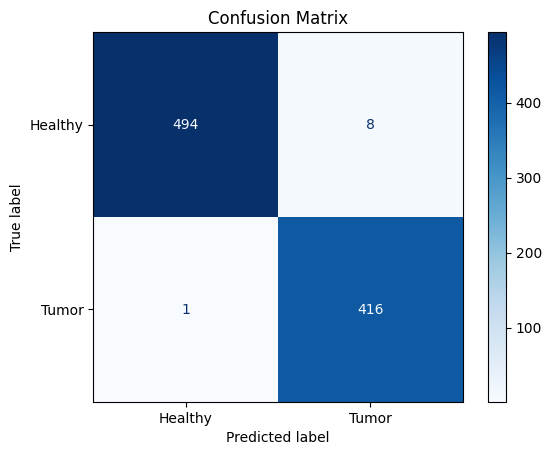

              precision    recall  f1-score   support

     Healthy       1.00      0.98      0.99       502
       Tumor       0.98      1.00      0.99       417

    accuracy                           0.99       919
   macro avg       0.99      0.99      0.99       919
weighted avg       0.99      0.99      0.99       919



In [ ]:
'''#Confusion Matrix
#Vorhersagen (liefert Wahrscheinlichkeiten)
vorhersage=cnn_model.predict(validierung)

#Wenn binary classification: Schwelle setzen
pred_labels=(vorhersage > 0.5).astype(int).flatten()

#Echte Labels extrahieren
true_labels = validierung.classes

#Confusion Matrix erzeugen & anzeigen:
matrix=confusion_matrix(true_labels, pred_labels)
disp=ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=['Healthy', 'Tumor'])

plt.figure(figsize=(5, 5))
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix")
plt.show()

#Optional: Klassifikationsbericht
#Zeigt Precision, Recall und F1-Score:

print(classification_report(true_labels, pred_labels, target_names=['Healthy', 'Tumor']))'''

<Axes: >

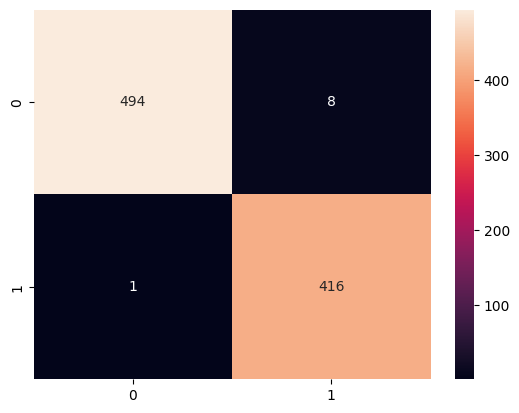

In [ ]:
'''sns.heatmap(matrix, annot=True, fmt = 'g')'''

In [ ]:
#help(models.Sequential)
#help(cnn_model.compile)
#help(cnn_model.fit)
#help(confusion_matrix)